# Facial Keyponts Detection

https://www.kaggle.com/c/facial-keypoints-detection

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from pandas.io.parsers import read_csv
from random import randrange
from time import time

import torch
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import sys
sys.path.append('../')
from pycoach.coach import Coach

In [2]:
# verifica se a GPU esta disponivel
use_gpu = torch.cuda.is_available()
print("Usando GPU:", use_gpu)

Usando GPU: True


## Carregando os dados

In [3]:
class FacialKeypointsDataset(Dataset):
    """Facial Keypoints dataset."""

    def __init__(self, csv_file, transform=None):
        """
        csv_file (string): caminho para o csv com as anotações e imagens.
        transform (callable, optional): Transformação opcional para aplicar na amostra
        """
        # cria dataframe descartando amostras com dados faltando
        self.facial_keypoints = read_csv(csv_file)
        # descarta linhas com dados faltando
        self.facial_keypoints = self.facial_keypoints.dropna()
        # recria os índices
        self.facial_keypoints = self.facial_keypoints.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.facial_keypoints)

    def __getitem__(self, idx):
        # carrega imagem
        image = self.facial_keypoints['Image'][idx]
        # converte string para imagem
        image = np.fromstring(image, sep=' ')
        # carrega keypoints como matriz
        keypoints = self.facial_keypoints.iloc[idx, :-1].as_matrix().astype('float')
        # dicionário com a imagen e os keypoints
        sample = {'image': image, 'keypoints': keypoints}

        # aplica transformação
        if self.transform:
            sample = self.transform(sample)

        return sample

In [4]:
train_file = 'data/training.csv'

## Classes de transformações dos dados

In [5]:
class ToTensor(object):
    """
    Converte amostra de ndarrays para Tensors.
    """
    def __call__(self, sample):
        image, keypoints = sample['image'], sample['keypoints']

        # imagem numpy: H x W x C
        # imagem torch: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'keypoints': torch.from_numpy(keypoints)}

In [6]:
class Normalize(object):
    """
    Normaliza amostra
    """
    def __call__(self, sample, image_size=96, channels=1):
        """
        sample: amostra para normalização
        image_size: tamanho da imagem
        channels: canais para conversão
        """
        image, keypoints = sample['image'], sample['keypoints']
        image = np.vstack(image) / 255.
        image = image.astype(np.float32)
        image = image.reshape(image_size, image_size, channels)

        # aplica transformação somente no conjunto de treino
        if keypoints.shape[0] > 1:
            keypoints = (keypoints - 48) / 48  # coloca os dados entre [-1, 1]
            keypoints = keypoints.astype(np.float32)

        return {'image': image, 'keypoints': keypoints}

In [7]:
class Flip(object):
    """
    Gira amostra.
    """
    def __init__(self, chance=0.5):
        self.flip_indices = [
            (0, 2), (1, 3),
            (4, 8), (5, 9), (6, 10), (7, 11),
            (12, 16), (13, 17), (14, 18), (15, 19),
            (22, 24), (23, 25),
        ]
        self.chance = chance

    def __call__(self, sample):
        """
        sample: amostra para girar
        chance: chance da imagem sofrer transformação
        """
        image, keypoints = sample['image'], sample['keypoints']
        if np.random.random() < self.chance:
            # gira a imagem
            image = image[:, ::-1, :].copy()
            # gira os keypoints horizontais
            keypoints[::2] = keypoints[::2] * -1
            # ajusta colunas
            for a, b in self.flip_indices:
                keypoints[a], keypoints[b] = (keypoints[b], keypoints[a])
            
        return {'image': image, 'keypoints': keypoints}

In [8]:
facial_dataset = FacialKeypointsDataset(train_file, 
                                       transform=transforms.Compose([
                                           Normalize(),
                                           Flip(0.7),
                                           #ToTensor(),
                                       ]))

## Plotando alguns exemplos

In [9]:
def plot_image(x, y):
    '''
    Plota uma imagem com os keypoints

    x: imagem
    y: keypoints
    '''
    img = x.reshape(96, 96)
    plt.imshow(img, cmap='gray')
    plt.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, c='cyan', marker='o', s=10)

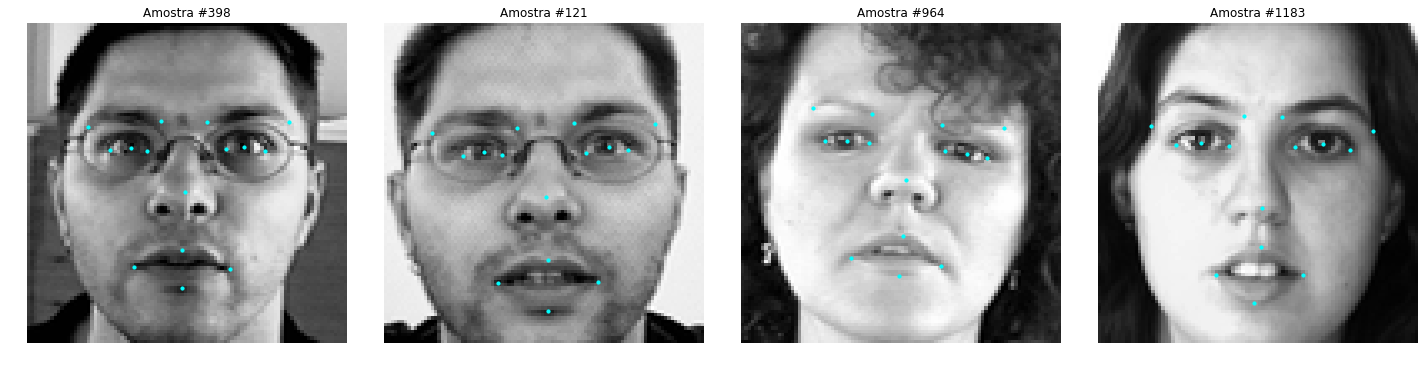

In [10]:
fig = plt.figure(figsize=(20,7))

for i in range(4):
    img = randrange(0, len(facial_dataset))
    sample = facial_dataset[img]

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Amostra #{}'.format(img))
    ax.axis('off')
    plot_image(sample['image'], sample['keypoints'])

plt.show()

In [11]:
del facial_dataset

In [12]:
facial_dataset_train = FacialKeypointsDataset(train_file, 
                                       transform=transforms.Compose([
                                           Normalize(),
                                           Flip(1),
                                           ToTensor(),
                                       ]))

facial_dataset_validate = FacialKeypointsDataset(train_file, 
                                       transform=transforms.Compose([
                                           Normalize(),
                                           ToTensor(),
                                       ]))

## Cria DataLoader

In [14]:
train_loader = torch.utils.data.DataLoader(facial_dataset_train,
                                          batch_size=64,
                                          shuffle=True,
                                          num_workers=1)

validate_loader = torch.utils.data.DataLoader(facial_dataset_validate,
                                          batch_size=64,
                                          shuffle=False,
                                          num_workers=1)

## Construindo o modelo

In [15]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(1, 32, 3)
        self.conv2 = torch.nn.Conv2d(32, 64, 3)
        self.pool1 = torch.nn.MaxPool2d(2, 2)
        self.drop1 = torch.nn.Dropout(0.25)
        
        self.conv3 = torch.nn.Conv2d(64, 48, 3)
        self.pool2 = torch.nn.MaxPool2d(2, 2)
        self.drop2 = torch.nn.Dropout(0.25)
        
        self.dense1 = torch.nn.Linear(48 * 22 * 22, 512)
        self.drop3 = torch.nn.Dropout(0.2)
        self.dense2 = torch.nn.Linear(512, 30)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = self.drop1(x)
        
        x = F.relu(self.conv3(x))
        x = self.pool2(x)
        x = self.drop2(x)
        
        x = x.view(-1, 48 * 22 * 22)
        x = F.relu(self.dense1(x))
        x = self.drop3(x)
        x = self.dense2(x)
        return x

In [16]:
net = Net()

if use_gpu:
    net.cuda()

print(net)

Net (
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (drop1): Dropout (p = 0.25)
  (conv3): Conv2d(64, 48, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (drop2): Dropout (p = 0.25)
  (dense1): Linear (23232 -> 512)
  (drop3): Dropout (p = 0.2)
  (dense2): Linear (512 -> 30)
)


## Compilando e treinando

In [17]:
loaders = {'train': train_loader, 'validate': validate_loader}
optimizer = torch.optim.Adam(net.parameters())
loss_fn = torch.nn.MSELoss()
epochs = 100

In [18]:
coach = Coach(net, loaders, optimizer, loss_fn)

In [19]:
coach.train(epochs)

Epoch: 0 - 70.0 s 	 train loss: 0.05466 	 val loss: 0.03091
Loss improved, saving model from epoch 0
Epoch: 1 - 69.0 s 	 train loss: 0.00855 	 val loss: 0.03698
Epoch: 2 - 69.0 s 	 train loss: 0.00732 	 val loss: 0.02443
Loss improved, saving model from epoch 2
Epoch: 3 - 72.0 s 	 train loss: 0.00664 	 val loss: 0.02511
Epoch: 4 - 69.0 s 	 train loss: 0.00624 	 val loss: 0.03014
Epoch: 5 - 69.0 s 	 train loss: 0.00593 	 val loss: 0.02514
Epoch: 6 - 69.0 s 	 train loss: 0.00578 	 val loss: 0.02598
Epoch: 7 - 69.0 s 	 train loss: 0.00566 	 val loss: 0.01596
Loss improved, saving model from epoch 7
Epoch: 8 - 69.0 s 	 train loss: 0.00513 	 val loss: 0.01807
Epoch: 9 - 69.0 s 	 train loss: 0.0049 	 val loss: 0.01495
Loss improved, saving model from epoch 9
Epoch: 10 - 69.0 s 	 train loss: 0.00486 	 val loss: 0.01123
Loss improved, saving model from epoch 10
Epoch: 11 - 71.0 s 	 train loss: 0.00439 	 val loss: 0.0125
Epoch: 12 - 70.0 s 	 train loss: 0.00416 	 val loss: 0.00865
Loss improved

## Salva modelo

In [27]:
coach.save('./net-flip.pytorch')

## Visualizando o erro de treinamento e validação

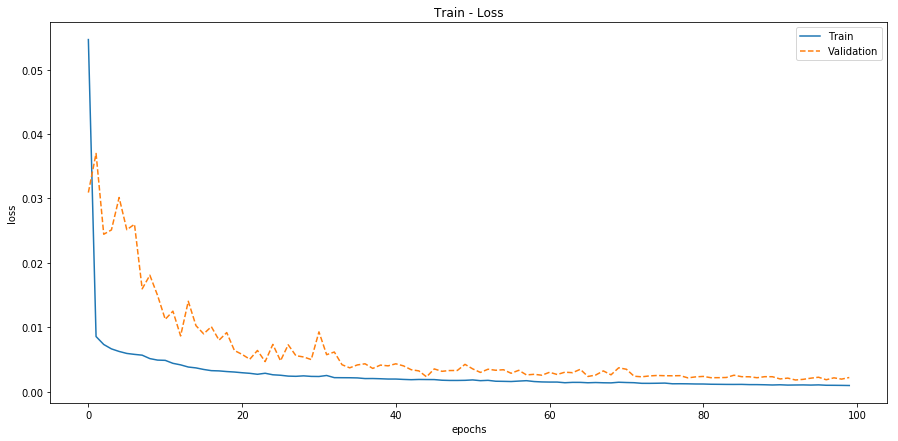

In [26]:
fig = plt.figure(figsize=(15,7))
plt.title('Train - Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(range(epochs), coach.train_loss, '-', label='Train')
plt.plot(range(epochs), coach.val_loss, '--', label='Validation')
plt.legend()
plt.show()

## Avaliando a rede no conjunto de testes

In [18]:
coach.load('./net-flip.pytorch')

In [28]:
def load(file, test=False, cols=None):
    '''
    Carrega o dataset.
    
    file: arquivo a ser carregado
    test: indica se o arquivo contém dados de teste ou treino
    cols: carrega algumas colunas específicas
    '''

    # carrega os dados como dataframe do pandas
    df = read_csv(file)

    # converte os dados para array numpy
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep = ' '))

    # seleciona somente algumas colunas
    if cols:
        df = df[list(cols) + ['Image']]

    # descarta linhas com dados faltando
    df = df.dropna()

    if not test:  # only FTRAIN has target columns
        y = df[df.columns[:-1]].values
    else:
        y = np.zeros((df.shape[0],))

    return (df, y)

In [29]:
test_file = 'data/test.csv'

In [30]:
X_test, y_test = load(test_file, test=True)

In [31]:
def normalize(X, y=None, image_size=96, channels=1):
    '''
    Normaliza os dados
    
    X: imagens para normalização
    y: labels para normalização
    image_size: tamanho da imagem
    channels: canais para conversão
    '''
    
    X = np.vstack(X['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)
    X = X.reshape(-1, channels, image_size, image_size)

    if y is not None:
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
        y = y.astype(np.float32)
        
    return (X, y)

In [32]:
channels = 1
image_size = 96

X_test, _ = normalize(X_test, image_size=image_size, channels=channels)

print(X_test.shape)

(1783, 1, 96, 96)


In [33]:
X_test = torch.from_numpy(X_test).type(torch.FloatTensor)
y_test = torch.from_numpy(y_test).type(torch.FloatTensor)

test = torch.utils.data.TensorDataset(X_test, y_test)

test_loader = torch.utils.data.DataLoader(test,
                                         batch_size=10,
                                         shuffle=False,
                                         num_workers=2)

In [34]:
y_predicted = coach.predict(test_loader)

In [35]:
y_predicted.size()

torch.Size([1783, 30])

In [36]:
if use_gpu:
    y_predicted = y_predicted.cpu()

## Visualizando algumas previsões

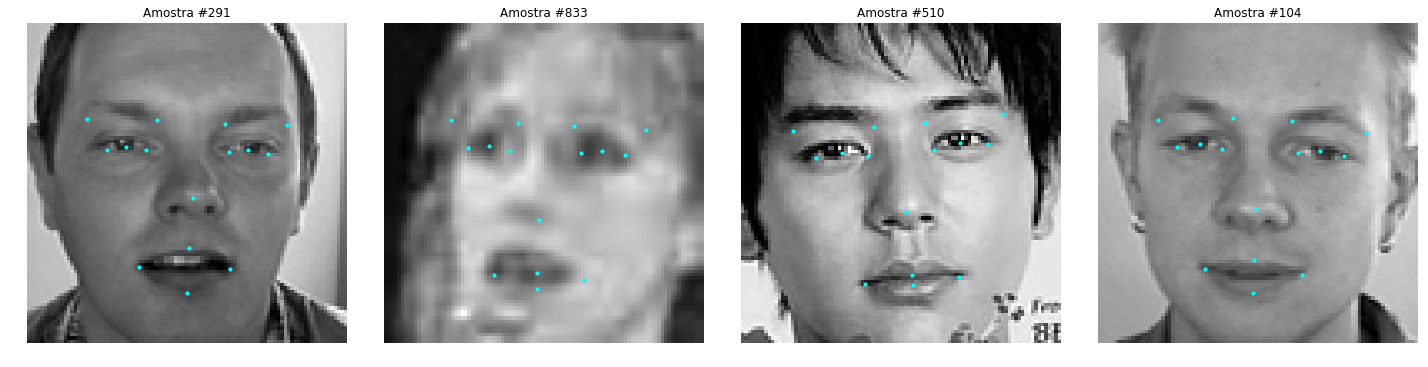

In [52]:
fig = plt.figure(figsize=(20,7))

for i in range(4):
    img = randrange(0, X_test.size()[0])

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Amostra #{}'.format(img))
    ax.axis('off')
    plot_image(X_test[img].numpy(), y_predicted[img].numpy())

plt.show()